The goal is to create a data density map based on the information available in the index files.<br>
The index files don't contain the data locations, but rectangular boxes in which the data of each file are distributed.<br>
We therefore use this information to derive an indication of the data density on a pre-defined grid.

In [52]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import rcParams
%matplotlib inline

In [53]:
rcParams.update({'font.size': 22})

Let's assume we have all the index files in a common directory.

In [40]:
indexfile_basedir = "/home/ctroupin/DataOceano/CMEMS/IndexFiles/"
indexfile_dirlist = ['Arctic', 'Baltic', 'BlackSea', 'Global', 'IBI', 'MedSea', 'NorthWestShelves']
indexfile_type = 'history'
figdir = "/home/ctroupin/DataOceano/CMEMS/IndexFiles/figures"

Generate a list of files to process

In [41]:
indexfile_list = []
for regions in indexfile_dirlist:
    indexfile_list.append(sorted(glob.glob(os.path.join(indexfile_basedir + regions, '*' + indexfile_type + '*'))))

# Functions 

Some functions we will use in the code:
* read_index_file_box to read the coordinates inside a given domain,
* create_rectangle to detect if data are available in a grid cell.

In [42]:
def read_index_file_box(indexfile):
    dataindex = np.genfromtxt(indexfile, skip_header=6, unpack=True, delimiter=',', dtype=None, \
              names=['catalog_id', 'file_name', 'geospatial_lat_min', 'geospatial_lat_max',
                     'geospatial_lon_min', 'geospatial_lon_max',
                     'time_coverage_start', 'time_coverage_end', 
                     'provider', 'date_update', 'data_mode', 'parameters'])
    lon_min = dataindex['geospatial_lon_min']
    lon_max = dataindex['geospatial_lon_max']
    lat_min = dataindex['geospatial_lat_min']
    lat_max = dataindex['geospatial_lat_max']
    goodcoord = np.where((lon_max<=180.) & (lon_min>=-180.) & (lat_min>=-90.) & (lat_max<=90.))[0]
    return lon_min[goodcoord], lon_max[goodcoord], lat_min[goodcoord], lat_max[goodcoord]

In [43]:
def create_rectangle(lon_min, lon_max, lat_min, lat_max, lon_grid, lat_grid, resolution):
    '''
    Rectangle is a matrix containg 1's where inside the domain defined by the data coverage (lon/lat min/max). 
    It is computed by a product of 2 vectors.
    '''
    lon_vec = np.zeros_like(lon_grid)
    lat_vec = np.zeros_like(lat_grid)
    lon_vec[(lon_grid >= lon_min - resolution) & (lon_grid <= lon_max + resolution)] = 1
    lat_vec[(lat_grid >= lat_min - resolution) & (lat_grid <= lat_max + resolution)] = 1
    rectangle = lat_vec.T*lon_vec
    return rectangle

# Generate grid based on resolution

In [44]:
resolution = 1.
lon_grid = np.array([np.arange(-180., 180., resolution)],)
lat_grid = np.array([np.arange(-90., 90., resolution)],)

Prepare the projection (one time is enough)

In [45]:
m = Basemap(lon_0=0, projection='robin')
llon, llat = np.meshgrid(lon_grid[0], lat_grid[0])
lonmap, latmap = m(llon, llat)

# Loop on the index file

In [46]:
for indexfile in indexfile_list:
    print('Working on %s' %(indexfile[0]))
    # Read the coordinates
    lon_min, lon_max, lat_min, lat_max = read_index_file_box(indexfile[0])
    # Data count
    rectangle_sum = np.zeros_like(lat_grid.T*lon_grid)
    for lon_min0, lon_max0, lat_min0, lat_max0 in zip(lon_min, lon_max, lat_min, lat_max):
        rectangle = create_rectangle(lon_min0, lon_max0, lat_min0, lat_max0, lon_grid, lat_grid, resolution)
        rectangle_sum += rectangle
    # Plot on the map
    lonmean = 0.5*(lon_min + lon_max)
    latmean = 0.5*(lat_min + lat_max)
    lonmeanmap, latmeanmap = m(lonmean, latmean)

    
    figname = regions + os.path.basename(indexfile[0])[:-3]
    fig = plt.figure(figsize=(15, 10))
    m.drawmapboundary(color='w')
    m.pcolor(lonmap, latmap, rectangle_sum, cmap=cmap)
    #plt.plot(lonmeanmap, latmeanmap, 'wo', markerfacecolor='w', markeredgecolor='w', markersize=0.5)
    m.drawcountries(linewidth=0.5, color='w')
    m.drawcoastlines(linewidth=0.5, color='w')
    m.fillcontinents()
    cbar = plt.colorbar()
    plt.savefig(os.path.join(figdir, figname))
    plt.close()
    
    
    

Working on /home/ctroupin/DataOceano/CMEMS/IndexFiles/Arctic/index_history.txt
Working on /home/ctroupin/DataOceano/CMEMS/IndexFiles/Baltic/index_history.txt
Working on /home/ctroupin/DataOceano/CMEMS/IndexFiles/BlackSea/index_history.txt


ValueError: Some errors were detected !
    Line #262 (got 12 columns instead of 13)
    Line #266 (got 12 columns instead of 13)
    Line #716 (got 12 columns instead of 13)

In [48]:
aa = "/home/ctroupin/DataOceano/CMEMS/IndexFiles/Arctic/index_history.txt"

In [50]:
aa.split('/')[-2]

'Arctic'

In [51]:
indexfile_list

[['/home/ctroupin/DataOceano/CMEMS/IndexFiles/Arctic/index_history.txt'],
 ['/home/ctroupin/DataOceano/CMEMS/IndexFiles/Baltic/index_history.txt'],
 ['/home/ctroupin/DataOceano/CMEMS/IndexFiles/BlackSea/index_history.txt'],
 ['/home/ctroupin/DataOceano/CMEMS/IndexFiles/Global/index_history.txt'],
 ['/home/ctroupin/DataOceano/CMEMS/IndexFiles/IBI/index_history.txt'],
 ['/home/ctroupin/DataOceano/CMEMS/IndexFiles/MedSea/index_history.txt'],
 ['/home/ctroupin/DataOceano/CMEMS/IndexFiles/NorthWestShelves/index_history.txt']]

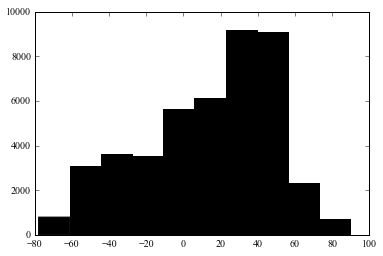

In [58]:
plt.hist(latmean)
plt.show()

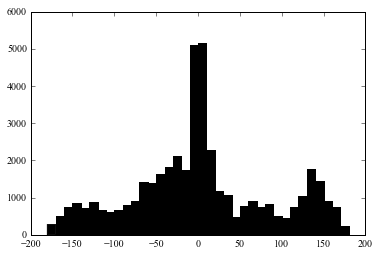

In [60]:
bins = np.arange(-180., 180.00001, 10.)
plt.hist(lonmean, bins)
plt.show()

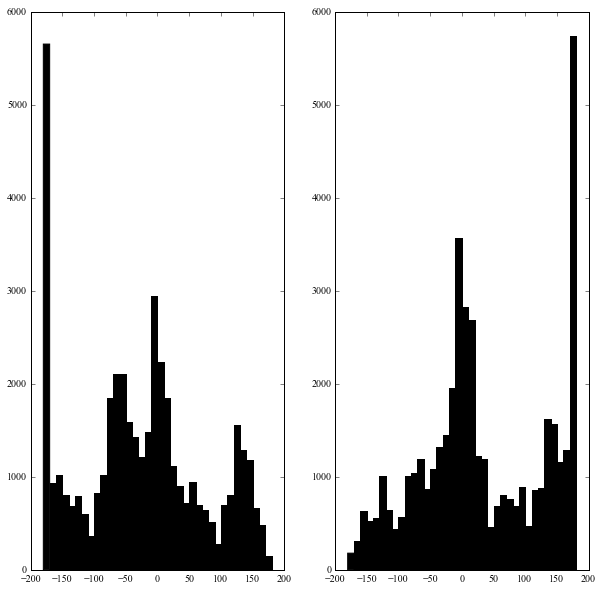

In [64]:
bins = np.arange(-180., 180.00001, 10.)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(121)
plt.hist(lon_min, bins)
ax = plt.subplot(122)
plt.hist(lon_max, bins)
plt.show()